<a href="https://colab.research.google.com/github/crlsyajie/Machine-Learning-Models/blob/main/LibericaXExcelsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
excelsa_dir = '/content/drive/MyDrive/LibericaxExcelsa/Excelsa'
liberica_dir = '/content/drive/MyDrive/LibericaxExcelsa/Liberica'
image_size = (224, 224)
label_map = {'Excelsa': 0, 'Liberica': 1}


In [ ]:
def calculate_eccentricity(contour):
    if len(contour) < 5:
        return 0
    ellipse = cv2.fitEllipse(contour)
    major = max(ellipse[1])
    minor = min(ellipse[1])
    if major == 0:
        return 0
    return np.sqrt(1 - (minor / major) ** 2)

def preprocess_and_extract(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    image = cv2.resize(image, image_size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    c = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)
    bean_only = cv2.bitwise_and(image, image, mask=mask)

    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    aspect_ratio = float(w) / h
    perimeter = cv2.arcLength(c, True)
    circularity = 4 * np.pi * (area / (perimeter**2)) if perimeter != 0 else 0
    eccentricity = calculate_eccentricity(c)

    hu = cv2.HuMoments(cv2.moments(c)).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    hull = cv2.convexHull(c, returnPoints=True)
    angles = []
    for i in range(len(hull)):
        p1 = hull[i - 1][0]
        p2 = hull[i][0]
        p3 = hull[(i + 1) % len(hull)][0]
        v1 = p1 - p2
        v2 = p3 - p2
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10))
        angles.append(np.degrees(angle))
    tip_sharpness = np.mean(sorted(angles)[:2])

    binarized = (closed > 0).astype(np.uint8)
    skeleton = skeletonize(invert(binarized))
    coords = np.argwhere(skeleton)

    if coords.shape[0] < 2:
        coeffs = [0, 0, 0]
    else:
        curve_x = coords[:,1]
        curve_y = coords[:,0]
        coeffs = np.polyfit(curve_x, curve_y, deg=2)

    features = [
        area, w, h, aspect_ratio, circularity,
        eccentricity, tip_sharpness
    ] + coeffs.tolist() + hu_log.tolist()

    return bean_only / 255.0, features


In [ ]:
X_img, X_shape, y = [], [], []

def process_folder(folder_path, label_name):
    label = label_map[label_name]
    for file in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
        if not file.lower().endswith(('.jpg', '.png')):
            continue
        path = os.path.join(folder_path, file)
        img_data, features = preprocess_and_extract(path)
        if img_data is not None and features is not None:
            X_img.append(img_data)
            X_shape.append(features)
            y.append(label)
        else:
            print(f"⚠️ Skipped {file}: no contour or curve found")

process_folder(liberica_dir, 'Liberica')
process_folder(excelsa_dir, 'Excelsa')


Processing Excelsa: 100%|██████████| 55/55 [00:25<00:00,  2.18it/s]


In [ ]:
if len(X_shape) == 0:
    raise ValueError("❌ No features extracted. Check dataset.")

X_img = np.array(X_img)
X_shape = StandardScaler().fit_transform(np.array(X_shape))
y = to_categorical(y)

X_img_train, X_img_val, X_shape_train, X_shape_val, y_train, y_val = train_test_split(
    X_img, X_shape, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
img_input = Input(shape=(224, 224, 3), name='img_input')
x = layers.Conv2D(32, (3,3), activation='relu')(img_input)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

shape_input = Input(shape=(X_shape.shape[1],), name='shape_input')
y = layers.Dense(64, activation='relu')(shape_input)
y = layers.BatchNormalization()(y)

combined = layers.Concatenate()([x, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(2, activation='softmax')(z)

model = Model(inputs=[img_input, shape_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shape_input         │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,152 │ shape_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,650 (483.01 KB)

 Trainable params: 123,522 (482.51 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    {"img_input": X_img_train, "shape_input": X_shape_train},
    y_train,
    validation_data=(
        {"img_input": X_img_val, "shape_input": X_shape_val},
        y_val
    ),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3011 - loss: 1.1752 - val_accuracy: 0.6087 - val_loss: 0.4595
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8243 - loss: 0.3918 - val_accuracy: 0.6957 - val_loss: 0.3672
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9899 - loss: 0.1092 - val_accuracy: 1.0000 - val_loss: 0.2502
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9969 - loss: 0.0810 - val_accuracy: 1.0000 - val_loss: 0.1652
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9899 - loss: 0.0608 - val_accuracy: 1.0000 - val_loss: 0.1635
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9854 - loss: 0.0751 - val_accuracy: 1.0000 - val_loss: 0.1980
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.1770
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9854 - loss: 0.0414 - val_accuracy: 1.0000 - val_loss: 0.0934
Epoch 9/

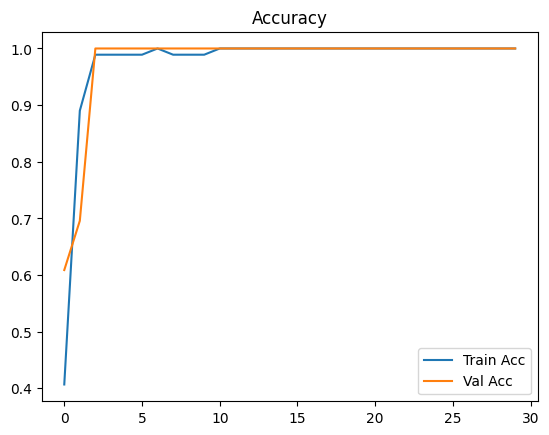

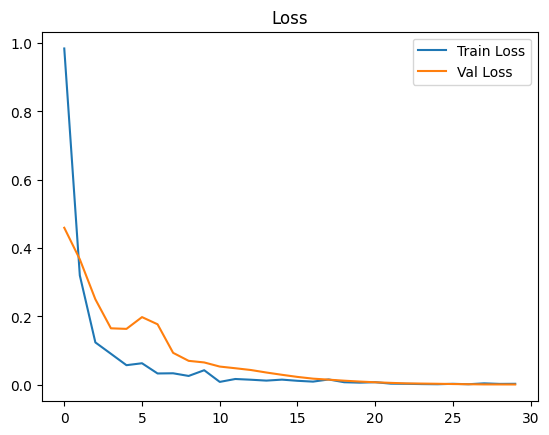

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('/content/final_hybrid_model_shape_only.h5')


Saving Screenshot 2025-07-31 193324.png to Screenshot 2025-07-31 193324 (4).png


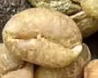

In [ ]:
from google.colab import files
from IPython.display import Image as IPImage, display

# Upload image from local device
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Display the uploaded image
display(IPImage(filename=img_path))

# Prediction function using the hybrid model
def predict_hybrid(img_path, excelsa_thresh=0.6, liberica_thresh=0.6):
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Could not load image.")
        return

    img = cv2.resize(img, image_size)
    _, features = preprocess_and_extract(img_path)
    if features is None:
        print("❌ Could not extract features.")
        return

    img_input = np.expand_dims(img / 255.0, axis=0)
    shape_input = np.expand_dims(features, axis=0)

    pred = model.predict({"img_input": img_input, "shape_input": shape_input})[0]
    classes = ['Liberica', 'Excelsa']

    liberica_score = pred[0]
    excelsa_score = pred[1]

    print("🔍 Prediction Confidence:")
    print(f"  Liberica: {liberica_score * 100:.2f}%")
    print(f"  Excelsa: {excelsa_score * 100:.2f}%")

    if excelsa_score >= excelsa_thresh:
        print(f"\n✅ Final Prediction: Excelsa (≥ {excelsa_thresh*100:.0f}%)")
    elif liberica_score >= liberica_thresh:
        print(f"\n✅ Final Prediction: Liberica (≥ {liberica_thresh*100:.0f}%)")
    else:
        print("\n⚠️ Prediction is uncertain.")




In [ ]:
predict_hybrid(img_path, excelsa_thresh=0.10, liberica_thresh=1.00)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
🔍 Prediction Confidence:
  Liberica: 100.00%
  Excelsa: 0.00%

✅ Final Prediction: Liberica (≥ 100%)
